# Imbalance optimization model development

This notebook contains experiments and research, that led to the development of the trading model. The most promising results from this notebook are further developed into an automatic model. Results of case study are analyzed and forecasting module are developed in different notebook.  


Development of the imbalance optimization strategy and simulation, using march 2022 data.  
Model the problem, using classic News Vendor problem as a basis.




## Table of contents

* [Problem formulation](#problem)
* [Data Preparation](#prep)
* [Simpler strategies analysis](#baseline)
    * [Day-Ahead](#da)
    * [Static tweaking](#tau)
* [Advancing the strategy](#advanced)
    * [Wind power forecast error modelling](#forecast_error)
    * [Interface for using stochasic programming](#static_alpha)
    * [Development of loss function](#loss_fun)
    * [Tests with more advanced strategy](#tests)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 

from scipy.stats import norm, shapiro, jarque_bera, norminvgauss
from scipy.special import ndtri, ndtr
from scipy.stats import weibull_min

import scipy.stats as st

from scipy.optimize import differential_evolution

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

import seaborn as sns

/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


<a id='problem'></a>
## Problem formulation

News Vendor is a stochastic programming problem class with characteristics:

* One shot decision variable, that is unknown and realizes in future (generation position)
* Actual generation is not certain
* Known marginal Profit & Loss (we have predictions)

We want to maximize profits, which is equivalent to minimizing balancing costs.

### Marginal prices of deviation from production plan

$$\pi_i^+ = \lambda_i^S - \lambda_i^\downarrow$$
$$\pi_i^- = \lambda_i^\uparrow - \lambda_i^S$$


$\lambda_i^S$ Spot price  
$\lambda_i^\downarrow$ DOWN regulation price  
$\pi_i^+$  Opportunity cost. Spread between Spot and DOWN regulation price  

$\lambda_i^\uparrow$ UP regulation price    
$\pi_i^+$  Penalty for producing less than promised. Spread between Spot and UP regulation price


The spreads are unknown and are one of the most important variable in this model.


### The one-shot decision variable 

We get optimal quantile for i'th hour from 

$$E_i^* = F_i^{-1}(\alpha^*)$$

Optimal quantile comes from the loss function:  
$$\alpha^*=\frac{\pi_i^+}{\pi_i^+ + \pi_i^-}$$


$F_i(\alpha)$  Cumulative Distribution function of generated energy [MW]  
$\alpha^*$ Optimal quantile, to put our prediction


## Strategies

1. Trust the forecast
2. Tweak the forecast
3. Basic Newsvendor



---

<a id='prep'></a>
## Data preparation


3 basic dataframes:  
1) df_forecasts - DA, ID forecasts  
2) df_market_prices - Spot, balance markets price  
3) df_real - real measured generation  

In [2]:
df_forecasts = pd.read_excel('../../data/imbalance_strategy/full_case_study/EG_portfolio_2021-2022.xlsx')
for idx, each in df_forecasts.iloc[:, 0].iteritems():
    date = each.split('-')[0].strip()
    date = ''.join(date.split(','))
    
    date = datetime.datetime.strptime(date, '%d.%m.%Y %H:%M')
    df_forecasts.iloc[idx, 0] = date

df_forecasts.iloc[:, 0] = pd.to_datetime(df_forecasts.iloc[:, 0])
df_forecasts.index = df_forecasts.iloc[:, 0]  # Change the col to index with datetimes, instead of integers!
df_forecasts.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
df_forecasts

,EG DA Wind,Wind park ID position fixed 2 hours before,Wind park ID position fixed 3_hours_before
Unnamed: 0,,,
2021-01-01 00:00:00,19.6,21.283654,19.673898
2021-01-01 01:00:00,22.3,20.442779,20.278637
2021-01-01 02:00:00,20.7,22.023503,19.711593
2021-01-01 03:00:00,19.3,20.797317,20.636694
2021-01-01 04:00:00,18.1,17.463922,19.499845
...,...,...,...
2022-03-31 19:00:00,4.5,3.991464,3.715100
2022-03-31 20:00:00,4.7,3.327443,3.620040
2022-03-31 21:00:00,5.3,3.154586,3.692790


In [4]:
df_forecasts.index

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               ...
               '2022-03-31 14:00:00', '2022-03-31 15:00:00',
               '2022-03-31 16:00:00', '2022-03-31 17:00:00',
               '2022-03-31 18:00:00', '2022-03-31 19:00:00',
               '2022-03-31 20:00:00', '2022-03-31 21:00:00',
               '2022-03-31 22:00:00', '2022-03-31 23:00:00'],
              dtype='datetime64[ns]', name='Unnamed: 0', length=10919, freq=None)

In [5]:
df_prices= pd.read_excel('../../data/imbalance_strategy/full_case_study/DA_prices_2021-2022_EET.xlsx')
for idx, each in df_prices.iloc[:, 0].iteritems():
    date = datetime.datetime.strptime(each, '%Y-%m-%d %H:%M:%S')
    df_prices.iloc[idx, 0] = date
    

df_prices.iloc[:, 0] = pd.to_datetime(df_prices.iloc[:, 0])
df_prices.index = df_prices.iloc[:, 0]  # Change the col to index with datetimes, instead of integers!
df_prices.drop('Timestamp', axis=1, inplace=True)

In [6]:
df_prices

,DA_price
Timestamp,
2021-01-01 00:00:00,24.07
2021-01-01 01:00:00,24.95
2021-01-01 02:00:00,24.35
2021-01-01 03:00:00,23.98
2021-01-01 04:00:00,23.72
...,...
2022-03-18 19:00:00,275.31
2022-03-18 20:00:00,225.03
2022-03-18 21:00:00,50.10


In [7]:
df_imb_prices= pd.read_excel('../../data/imbalance_strategy/full_case_study/imbalance-prices_2021-2022.xlsx')
for idx, each in df_imb_prices.iloc[:, 0].iteritems():
    date = datetime.datetime.strptime(each, '%Y-%m-%d %H:%M')
    df_imb_prices.iloc[idx, 0] = date
    

df_imb_prices.iloc[:, 0] = pd.to_datetime(df_imb_prices.iloc[:, 0])
df_imb_prices.index = df_imb_prices.iloc[:, 0]  # Change the col to index with datetimes, instead of integers!
df_imb_prices.drop('From', axis=1, inplace=True)

df_imb_prices

,Imbalance price
From,
2021-01-01 00:00:00,105.92
2021-01-01 01:00:00,104.92
2021-01-01 02:00:00,35.27
2021-01-01 03:00:00,34.90
2021-01-01 04:00:00,34.64
...,...
2022-03-18 19:00:00,40.44
2022-03-18 20:00:00,338.56
2022-03-18 21:00:00,338.56


In [8]:
# Import real production data for evaluating strategies

df_real=pd.read_excel('../../data/imbalance_strategy/full_case_study/EG_real_2021-2022.xlsx')

# Parse datetimes into index
for idx, each in df_real.iloc[:, 0].iteritems():
    date = each.split('-')[0].strip()
    date = ''.join(date.split(','))
    
    date = datetime.datetime.strptime(date, '%d.%m.%Y %H:%M')
    df_real.iloc[idx, 0] = date

df_real.iloc[:, 0] = pd.to_datetime(df_real.iloc[:, 0])
df_real.index = df_real.iloc[:, 0]  # Change the col to index with datetimes, instead of integers!
df_real.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
df_real.head(15)

,Enefit Green AVP actuals\nWind farm total\nWind farm total\nMW
Unnamed: 0,
2021-01-01 00:00:00,26.107
2021-01-01 01:00:00,21.100
2021-01-01 02:00:00,20.762
2021-01-01 03:00:00,16.504
2021-01-01 04:00:00,13.700
2021-01-01 05:00:00,14.774
2021-01-01 06:00:00,15.411
2021-01-01 07:00:00,14.069
2021-01-01 08:00:00,5.578


Read in the total file

In [10]:
# df_all= pd.read_csv('../../data/imbalance_strategy/backtest_historical_data.csv')
# # for idx, each in df_prices.iloc[:, 0].iteritems():
# #     date = datetime.datetime.strptime(each, '%d.%m.%Y %H:%M')
# #     df_all.iloc[idx, 0] = date
    

# df_all.iloc[:, 0] = pd.to_datetime(df_all.iloc[:, 0])
# df_all.index = df_all.iloc[:, 0]  # Change the col to index with datetimes, instead of integers!
# df_all.drop('from', axis=1, inplace=True)
# df_all

In [11]:
df_system_imb_forecast = pd.read_excel('../forecast_analysis/exponential-smoothing_results.xlsx')

df_system_imb_forecast.iloc[:, 0] = pd.to_datetime(df_system_imb_forecast.iloc[:, 0])
df_system_imb_forecast.index = df_system_imb_forecast.iloc[:, 0]  # Change the col to index with datetimes, instead o
df_system_imb_forecast.drop(['Unnamed: 0'], inplace=True, axis=1)

In [12]:
df_system_imb_forecast

,forecasted,actual
Unnamed: 0,,
2021-01-01 00:00:00,25.289699,-74.881
2021-01-01 01:00:00,25.289699,-74.881
2021-01-01 02:00:00,-166.625376,-35.701
2021-01-01 03:00:00,-92.707865,-9.767
2021-01-01 04:00:00,-46.778014,-27.433
...,...,...
2022-02-28 19:00:00,58.450991,-56.687
2022-02-28 20:00:00,56.236963,-71.523
2022-02-28 21:00:00,-34.744725,-7.347


---

## Perfect information baseline

Calculate the max possible performance, assuming, we can make Day-Ahead bids with full certainty  
That is, balancing cost is 0

Assume, that DA_generation_forecast = actual_generation 

In [13]:
def calculate_perfect_revenue(df_spot, df_real) -> list:
    """
    Calculate revenues for each wind park, in each month 
    """
    QUANTITY_ACTUAL_IDX = 0
    
    SPOT_PRICE_IDX = 0
    ROUNDING_PRECISION = 2
    
    perfect_spot = []
    
    # First, look monthly data
    periods=['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03']

    
    for period in periods:
        perfect_gen_forecast_revenue = 0
        
        df_spot_period = df_spot.loc[period]
        df_real_period = df_real.loc[period]

        # Calculate total revenue for whole month
        for i in range(len(df_real_period)):

            # The DA sold wind is 1'st in the dataframe
            sold = df_real_period.iloc[i, QUANTITY_ACTUAL_IDX]
            price = df_spot_period.iloc[i,SPOT_PRICE_IDX]
            hour_revenue = sold * price
            perfect_gen_forecast_revenue += hour_revenue
            # print('Produced: ', sold)
            # print('money for mwh: ', price)
        print(f'Perfect Spot revenue in {period} is {round(perfect_gen_forecast_revenue, ROUNDING_PRECISION):,} EUR')
        perfect_spot.append(round(perfect_gen_forecast_revenue, ROUNDING_PRECISION))
        
    
    return perfect_spot

In [14]:
eg_perfect = calculate_perfect_revenue(df_prices, df_real)

Perfect Spot revenue in 2021-01 is 2,193,107.53 EUR
Perfect Spot revenue in 2021-02 is 2,175,418.67 EUR
Perfect Spot revenue in 2021-03 is 2,655,455.87 EUR
Perfect Spot revenue in 2021-04 is 2,015,695.54 EUR
Perfect Spot revenue in 2021-05 is 1,868,423.55 EUR
Perfect Spot revenue in 2021-06 is 1,248,509.45 EUR
Perfect Spot revenue in 2021-07 is 2,312,166.61 EUR
Perfect Spot revenue in 2021-08 is 3,973,589.49 EUR
Perfect Spot revenue in 2021-09 is 5,546,917.69 EUR
Perfect Spot revenue in 2021-10 is 7,604,991.96 EUR
Perfect Spot revenue in 2021-11 is 6,917,440.56 EUR
Perfect Spot revenue in 2021-12 is 10,284,437.9 EUR
Perfect Spot revenue in 2022-01 is 9,822,150.02 EUR
Perfect Spot revenue in 2022-02 is 6,032,999.01 EUR
Perfect Spot revenue in 2022-03 is 2,998,229.07 EUR


In [15]:
sum(eg_perfect)

67649532.92

<a id='baseline'></a>
## Functions for calculating revenues

In [16]:
def calculate_spot_revenue(df_forecast, df_spot, tau=1, alpha=None) -> list:
    """
    Calculate the real revenue from selling electricity to SPOT market. 
    tau - Coefficent, to multiply the mean forecst with
    alpha - Quantile of the forecast, to place in the market (DA or ID)
    """
    
    SOLD_QUANTITY_FORECAST_IDX = 0
    
    SPOT_PRICE_IDX = 0
    IMBALANCE_PRICE_IDX = 0
    ROUNDING_PRECISION = 2
    
    spot_revenues=[]
    
    if alpha:
        coefficent = alpha
    else:
        coefficent = tau
    
    # First, look monthly data
    periods=['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03']


    
    for period in periods:
        spot_revenue = 0
        
        df_spot_period = df_spot.loc[period]
        df_forecast_period = df_forecast.loc[period]

        # Calculate total revenue for whole month
        for i in range(len(df_spot_period)):
            
            # Choose the optimal quantile!
            if alpha:
                
                # ---- The choosing of determined quantile -----------
                forecasted_value = df_forecast_period.iloc[i, SOLD_QUANTITY_FORECAST_IDX]

                # Normal distribution N(X| error_mu+forecast, error_stderr)
                x = error_std * np.random.randn(1, 1000) + forecasted_value
                x = np.sort(x)
                
                y = 1. * np.arange(len(x[0])) / (len(x[0]) - 1)

                optimal_quantile_value = x[0][int(alpha*1000)]
                sold = optimal_quantile_value
            else:
                sold = coefficent * df_forecast_period.iloc[i, SOLD_QUANTITY_FORECAST_IDX]

            price = df_spot_period.iloc[i,SPOT_PRICE_IDX]
            hour_revenue = sold * price
            spot_revenue += hour_revenue
#             print('Sold: ', sold)
#             print('money for mwh: ', price)
        print(f'Spot revenue in {period} is {round(spot_revenue, ROUNDING_PRECISION):,} EUR')
        spot_revenues.append(round(spot_revenue, ROUNDING_PRECISION))
        
    
    return spot_revenues

In [17]:
eg_spot_revenue = calculate_spot_revenue(df_forecasts, df_prices)

Spot revenue in 2021-01 is 2,232,486.84 EUR
Spot revenue in 2021-02 is 2,091,879.85 EUR
Spot revenue in 2021-03 is 2,674,343.11 EUR
Spot revenue in 2021-04 is 1,984,032.03 EUR
Spot revenue in 2021-05 is 1,991,006.9 EUR
Spot revenue in 2021-06 is 1,323,961.56 EUR
Spot revenue in 2021-07 is 2,151,487.9 EUR
Spot revenue in 2021-08 is 4,221,907.14 EUR
Spot revenue in 2021-09 is 5,295,003.44 EUR
Spot revenue in 2021-10 is 7,416,634.69 EUR
Spot revenue in 2021-11 is 7,086,524.4 EUR
Spot revenue in 2021-12 is 10,550,084.18 EUR
Spot revenue in 2022-01 is 10,582,223.76 EUR
Spot revenue in 2022-02 is 6,055,850.28 EUR
Spot revenue in 2022-03 is 3,056,319.29 EUR


In [18]:
def calculate_balancing_revenue(df_forecast, df_spot, df_imbalance_price, df_real, tau=1, alpha=None) -> list:
    """
    Calculate the real revenue from selling electricity to SPOT market. 
    tau - Coefficent, to multiply the mean forecst with
    alpha - Quantile of the forecast, to place in the market (DA or ID)
    """
    
    SOLD_QUANTITY_FORECAST_IDX = 0    
    QUANTITY_ACTUAL_IDX = 0
    
    SPOT_PRICE_IDX = 0
    IMBALANCE_PRICE_IDX = 0
    ROUNDING_PRECISION = 2
    
    if alpha:
        coefficent = alpha
    else:
        coefficent = tau
        
    balancing_revenues = []
    
    # First, look monthly data
    periods=['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03']

    
    for period in periods:
        
        df_forecast_period = df_forecast.loc[period]
        df_spot_period = df_spot.loc[period]
        df_imbalance_period = df_imbalance_price.loc[period]
        df_real_period = df_real.loc[period]
        
        balancing_revenue = 0

        # Calculate total revenue for whole month
        for i in range(len(df_spot_period)):
            
            # Choose the optimal quantile!
            if alpha:
                
                # ---- The choosing of determined quantile -----------
    
                forecasted_value = df_forecast_period.iloc[i, SOLD_QUANTITY_FORECAST_IDX]

                # Normal distribution N(X| error_mu+forecast, error_stderr)
                x = error_std * np.random.randn(1, 1000) + forecasted_value
                x = np.sort(x)

                y = 1. * np.arange(len(x[0])) / (len(x[0]) - 1)

                optimal_quantile_value = x[0][int(alpha*1000)]
                
                sold = optimal_quantile_value
            else:
                sold = coefficent * df_forecast_period.iloc[i, SOLD_QUANTITY_FORECAST_IDX]

            
            production = df_real_period.iloc[i, QUANTITY_ACTUAL_IDX]
            
            # TWEAK THE FORECAST
            

            imbalance_price = df_imbalance_period.iloc[i, IMBALANCE_PRICE_IDX]
            # Have to sell on Balancing market
            if production > sold:
                surplus_generation = production - sold
                surplus = surplus_generation * imbalance_price
                balancing_revenue += surplus
            else:
                # Have to buy from Balancing market
                deficit_generation = sold - production
                deficit = deficit_generation * imbalance_price
                balancing_revenue -= deficit
        print(f'Balancing revenue for {period} is {round(balancing_revenue, ROUNDING_PRECISION):,} EUR')

        balancing_revenues.append(round(balancing_revenue, ROUNDING_PRECISION))
        
    
    return balancing_revenues

In [19]:
eg_balancing_revenue = calculate_balancing_revenue(df_forecasts, df_prices, df_imb_prices, df_real)

Balancing revenue for 2021-01 is -108,790.87 EUR
Balancing revenue for 2021-02 is 31,341.7 EUR
Balancing revenue for 2021-03 is -53,033.55 EUR
Balancing revenue for 2021-04 is -73,846.26 EUR
Balancing revenue for 2021-05 is -193,789.23 EUR
Balancing revenue for 2021-06 is -139,647.46 EUR
Balancing revenue for 2021-07 is 67,497.01 EUR
Balancing revenue for 2021-08 is -496,686.67 EUR
Balancing revenue for 2021-09 is 207,436.77 EUR
Balancing revenue for 2021-10 is -37,369.56 EUR
Balancing revenue for 2021-11 is -286,956.82 EUR
Balancing revenue for 2021-12 is -483,104.87 EUR
Balancing revenue for 2022-01 is -848,315.3 EUR
Balancing revenue for 2022-02 is -121,078.02 EUR
Balancing revenue for 2022-03 is -188,292.04 EUR


In [20]:
def calculate_total_performances(spot_revenue, balancing_revenue, perfect_revenue):
    """
    Given the different revenues as lists, calculate strategy performances.
    """
    total_revenues, performance_rates = [], []
    for month in range(len(spot_revenue)):
        total_revenue = spot_revenue[month] + balancing_revenue[month]
        optimal_performance = total_revenue/perfect_revenue[month]
        
        total_revenues.append(total_revenue)
        performance_rates.append(optimal_performance)
    return total_revenues, performance_rates

<a id='da'></a>
## Strategy 1 - trust the forecast

In [21]:
eg_perfect = calculate_perfect_revenue(df_prices, df_real)
eg_spot_revenue = calculate_spot_revenue(df_forecasts, df_prices)
eg_balancing_revenue = calculate_balancing_revenue(df_forecasts, df_prices,df_imb_prices, df_real)

total_revenues, performance_rates = calculate_total_performances(eg_spot_revenue, eg_balancing_revenue, eg_perfect)
performance_rates

Perfect Spot revenue in 2021-01 is 2,193,107.53 EUR
Perfect Spot revenue in 2021-02 is 2,175,418.67 EUR
Perfect Spot revenue in 2021-03 is 2,655,455.87 EUR
Perfect Spot revenue in 2021-04 is 2,015,695.54 EUR
Perfect Spot revenue in 2021-05 is 1,868,423.55 EUR
Perfect Spot revenue in 2021-06 is 1,248,509.45 EUR
Perfect Spot revenue in 2021-07 is 2,312,166.61 EUR
Perfect Spot revenue in 2021-08 is 3,973,589.49 EUR
Perfect Spot revenue in 2021-09 is 5,546,917.69 EUR
Perfect Spot revenue in 2021-10 is 7,604,991.96 EUR
Perfect Spot revenue in 2021-11 is 6,917,440.56 EUR
Perfect Spot revenue in 2021-12 is 10,284,437.9 EUR
Perfect Spot revenue in 2022-01 is 9,822,150.02 EUR
Perfect Spot revenue in 2022-02 is 6,032,999.01 EUR
Perfect Spot revenue in 2022-03 is 2,998,229.07 EUR
Spot revenue in 2021-01 is 2,232,486.84 EUR
Spot revenue in 2021-02 is 2,091,879.85 EUR
Spot revenue in 2021-03 is 2,674,343.11 EUR
Spot revenue in 2021-04 is 1,984,032.03 EUR
Spot revenue in 2021-05 is 1,991,006.9 EUR
S

[0.9683501337483438,
 0.9760059428008864,
 0.9871410741990602,
 0.94765589946188,
 0.9618898616429877,
 0.948582407606126,
 0.959699400727874,
 0.9374950480856037,
 0.991981586443912,
 0.9703185971547037,
 0.9829600299449484,
 0.9788555687618086,
 0.9910160647291762,
 0.9837184209980503,
 0.9565737583886478]

In [22]:
print(f'Average performance rate {np.array([performance_rates]).mean()}')

Average performance rate 0.9694829196462673


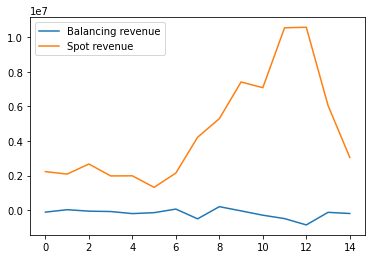

In [23]:
months_total = []
for i in range(len(eg_balancing_revenue)):
    rev = eg_balancing_revenue[i] + eg_spot_revenue[i]
    months_total.append(rev)
plt.plot(eg_balancing_revenue, label='Balancing revenue')
plt.plot(eg_spot_revenue, label='Spot revenue')
plt.legend()

### Conclusion

The "Trust the forecast" strategy yielded around 97% of the optimal (risk-averse) profits in period.

<a id='tau'></a>
## Tweak the forecast

Multiply the day-ahead forecast and thereby the sold amount with some coeficent $\tau$.  
Whether $\tau$ is over/under 1 depends on what we think will happen on balancing market.  

If balancing market will be dominated by UP direction, it is reasonable to choose $\tau$ < 1 value and $\tau$ > 1 if DOWN direction dominates  

In real world, if the values deviate too much from the original, the data is no longer valid, because it will influence the market.

In [24]:
TAU = 1.1

eg_perfect = calculate_perfect_revenue(df_prices, df_real)
eg_spot_revenue = calculate_spot_revenue(df_forecasts, df_prices, tau=TAU)
eg_balancing_revenue = calculate_balancing_revenue(df_forecasts, df_prices, df_imb_prices, df_real, tau=TAU)

total_revenues, performance_rates = calculate_total_performances(eg_spot_revenue, eg_balancing_revenue, eg_perfect)
performance_rates

Perfect Spot revenue in 2021-01 is 2,193,107.53 EUR
Perfect Spot revenue in 2021-02 is 2,175,418.67 EUR
Perfect Spot revenue in 2021-03 is 2,655,455.87 EUR
Perfect Spot revenue in 2021-04 is 2,015,695.54 EUR
Perfect Spot revenue in 2021-05 is 1,868,423.55 EUR
Perfect Spot revenue in 2021-06 is 1,248,509.45 EUR
Perfect Spot revenue in 2021-07 is 2,312,166.61 EUR
Perfect Spot revenue in 2021-08 is 3,973,589.49 EUR
Perfect Spot revenue in 2021-09 is 5,546,917.69 EUR
Perfect Spot revenue in 2021-10 is 7,604,991.96 EUR
Perfect Spot revenue in 2021-11 is 6,917,440.56 EUR
Perfect Spot revenue in 2021-12 is 10,284,437.9 EUR
Perfect Spot revenue in 2022-01 is 9,822,150.02 EUR
Perfect Spot revenue in 2022-02 is 6,032,999.01 EUR
Perfect Spot revenue in 2022-03 is 2,998,229.07 EUR
Spot revenue in 2021-01 is 2,455,735.52 EUR
Spot revenue in 2021-02 is 2,301,067.83 EUR
Spot revenue in 2021-03 is 2,941,777.43 EUR
Spot revenue in 2021-04 is 2,182,435.23 EUR
Spot revenue in 2021-05 is 2,190,107.58 EUR


[0.9505138309383308,
 0.9994505057732175,
 0.9897900807517469,
 0.9546211924445692,
 0.9855976071378463,
 0.9506684631021416,
 0.970184903760028,
 0.9262372419854571,
 1.0017121112175724,
 0.9805284396382189,
 0.9524969810510379,
 0.9615599292986152,
 1.0057048813025564,
 1.019281052393211,
 0.9479866326557898]

In [25]:
print(f'Average performance rate {np.array([performance_rates]).mean()}')

Average performance rate 0.9730889235633559


### Conclusion

Since the direction is volatile and centered around 0 mean equally, it is not advisable to select long-term coefficient. This will not give considerable improvement. 

Further research - Try to estimate short-term direction and modify the spot offers not with linear constats, but with actual probability distribution

<a id='advanced'></a>
## Strategy 3 - Basic News Vendor strategy


It is shown in Introduction to Stochastic Programming, that optimal solution for the news vendor problem is the $\alpha$ quantile of Cumulative Distribution function. 

Calculate the optimal quantile of production

First, we need to calculate the marginal profits, $\pi_i^+$ and $\pi_i^-$. The simplest way to define that loss function is to consider the historical spread data.

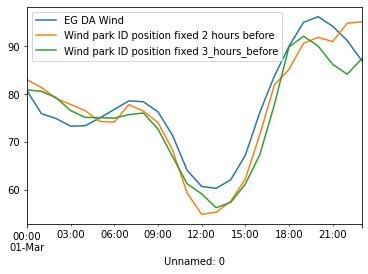

In [26]:
df_forecasts.loc['2022-03-01'].plot()
plt.show()

### Calculate historical spreads 

In [27]:
spreads = []

for i in range(len(df_real)):
    spot_price = df_prices.iloc[i, 0]
    imbalance_price = df_imb_prices.iloc[i, 0]
    spread = imbalance_price - spot_price
    spreads.append(spread)

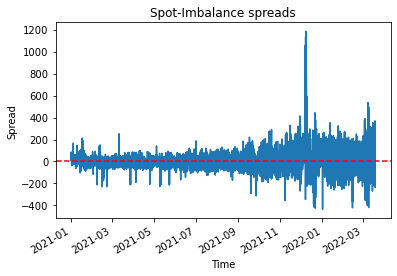

<Figure size 432x288 with 0 Axes>

In [28]:
df_imb_prices['spread']= spreads

df_imb_prices['spread'].plot()
plt.title("Spot-Imbalance spreads")
plt.axhline(y=0, c='r', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Spread")

plt.show()
plt.savefig('spot-imbalance-spread.png', pad_inches=0.2, dpi=300)

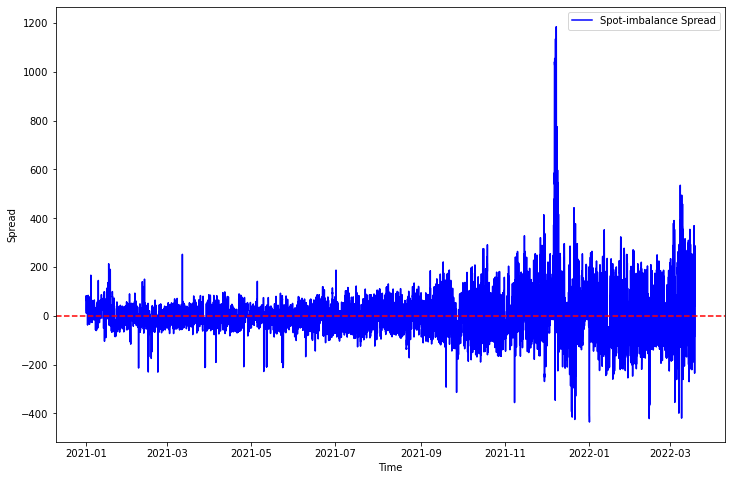

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Concat the observed and forecasted
ax.plot(df_imb_prices['spread'], label='Spot-imbalance Spread', c='b')
ax.axhline(y=0, c='r', linestyle='--')
ax.set_xlabel("Time")
ax.set_ylabel("Spread")
ax.legend()

plt.savefig('spot-imbalance-spread.png', pad_inches=0.2, dpi=300)

In [30]:
print("The mean spread is:", df_imb_prices['spread'].mean())

The mean spread is: 2.446224547511329


### Interpretation

The volatility has been going up since the september '21. It means that the same error for forecast is priced higher. Being on the right side, would be beneficcial to market, as well as company

**It is very hard, to calculate the loss function, as the spreads look like white noise!**  
==> Solution: Take system imbalance, since the spread depends on this anyway.
Use the forecast in order, to formulate the loss function (in which way, the error is more costly)

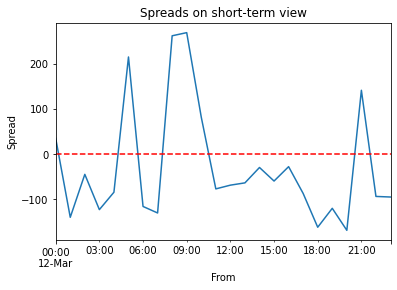

In [31]:
df_imb_prices.loc['2022-03-12','spread'].plot()
plt.axhline(y=0, c='r', linestyle='--')
plt.ylabel('Spread')
plt.title("Spreads on short-term view")
plt.show()

**Problems:**
1. We don't have probabilistic forecast  
2. We don't have loss function  

**Solutions:**
1. Fit the distribution, using different parametric distributions and compare to non-parametric
2. Compute the loss function, using ARIMA or other timeseries forecasting method  

In [32]:
df_forecasts

,EG DA Wind,Wind park ID position fixed 2 hours before,Wind park ID position fixed 3_hours_before
Unnamed: 0,,,
2021-01-01 00:00:00,19.6,21.283654,19.673898
2021-01-01 01:00:00,22.3,20.442779,20.278637
2021-01-01 02:00:00,20.7,22.023503,19.711593
2021-01-01 03:00:00,19.3,20.797317,20.636694
2021-01-01 04:00:00,18.1,17.463922,19.499845
...,...,...,...
2022-03-31 19:00:00,4.5,3.991464,3.715100
2022-03-31 20:00:00,4.7,3.327443,3.620040
2022-03-31 21:00:00,5.3,3.154586,3.692790


<a id='forecast_error'></a>
## Making the point forecast probabilistic

Fit the historical forecast errors, using maximum likelihood estimation.


NB! The data used to fit error distributions is out of the test sample, which the backtesting results are carried out!

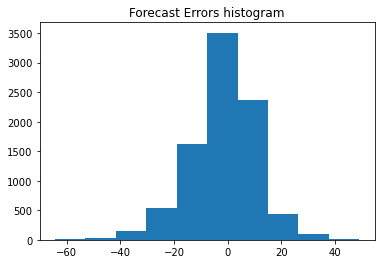

In [33]:
last_forecast = df_forecasts['Wind park ID position fixed 2 hours before']
last_forecast = last_forecast.loc[:'2021-12']

actual = df_real['Enefit Green AVP actuals\nWind farm total\nWind farm total\nMW']
actual = actual.loc[:'2021-12']

errors = last_forecast-actual
plt.hist(errors)
plt.title("Forecast Errors histogram")
plt.show()

In [34]:
# Remove nan values, to model probability distribution
errors = errors.dropna()

## Try fitting the error with normal distribution

In [35]:
# Use Maximum likelihood estimation, to fit the parameters of normal distribution (NOT THE BEST-)
error_mean, error_stderr = norm.fit(errors)
print(f"Fitted mean: {error_mean}")
print(f"Fitted stderr: {error_stderr}")

Fitted mean: -1.615043767703652
Fitted stderr: 12.325292537219324


/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


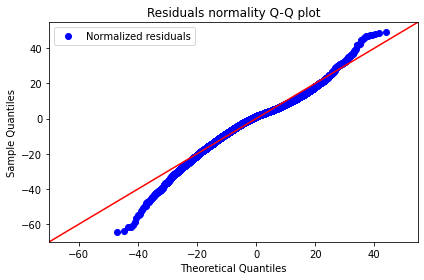

In [36]:
qqplot(errors, loc=error_mean, scale=error_stderr, line='45', label='Normalized residuals')

plt.title("Residuals normality Q-Q plot")
plt.legend()
plt.tight_layout()
plt.savefig('residuals_qq_plot.png', pad_inches=0.2, dpi=300)

### Interpretation:

The plot is comparing fitted normal distribution with empirical dataset 

The Q-Q plot shows, how well the data fits with distribution, by modelling the residuals. It can be seen, that most of the values fit well EXCEPT the lower end of the values.

==> Next step would be to try some non-symmetric distributions

In [37]:



jb = jarque_bera(errors)

print(f'The Jarque-Bera test statistic was: {jb.statistic} and corresponding p-value={jb.pvalue}')

The Jarque-Bera test statistic was: 1152.740320378081 and corresponding p-value=0.0


In [38]:
shapiro(errors)

/home/da5id/.local/lib/python3.9/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9765865206718445, pvalue=1.5515183771652512e-35)

### Hypothesis testing results

Jarque-Bera test: H1 - The data does not come from a normally distributed sample.  
Shapiro ttest H1: The data does not come from normally distributed sample

Text(0.5, 1.0, 'Inverse CDF of errors')

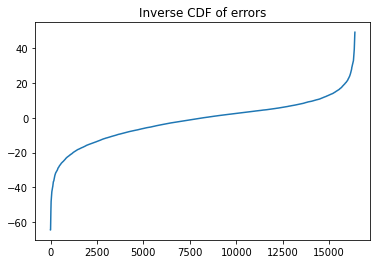

In [39]:
dens = sm.nonparametric.KDEUnivariate(errors)
dens.fit()
plt.plot(dens.icdf)
plt.title("Inverse CDF of errors")


In [40]:


data = errors
distributions = [st.laplace, st.norm, st.dweibull, st.gamma,st.lognorm, st.weibull_min, st.weibull_max, st.rayleigh]
mles = []

for distribution in distributions:
    pars = distribution.fit(data)
    mle = distribution.nnlf(pars, data)
    mles.append(mle)

results = [(distribution.name, mle) for distribution, mle in zip(distributions, mles)]
best_fit = sorted(zip(distributions, mles), key=lambda d: d[1])[0]
print('Best fit reached using {}, MLE value: {}'.format(best_fit[0].name, best_fit[1]))
print(results)

Best fit reached using dweibull, MLE value: 34187.221874087096
[('laplace', 34257.713974058366), ('norm', 34420.194039993934), ('dweibull', 34187.221874087096), ('gamma', 34516.0696972532), ('lognorm', 34440.938274807995), ('weibull_min', 61273.59858731441), ('weibull_max', 59075.73739161525), ('rayleigh', inf)]


### Interpretation

We want the smallest log-loss distribution.

In [41]:
errors.dropna(inplace=True)

In [42]:
# WITH AVP DATA
# y_weib = st.weibull_min.pdf(x_weib, c=2.2, loc=20, scale=20)
# Weibull parameters: c=12.158335763738343, loc=-141.3608096333395, scale=142.20387435192725


x_weib = np.linspace(-40, 40, 1000)
# WITH SCADA DATA
c_weibull, loc_weibull, scale_weibull=st.weibull_min.fit(errors)

rv = st.weibull_min.rvs(c_weibull, loc=loc_weibull, scale=scale_weibull)
# print(parameters)
frozen_dist = st.weibull_min(c_weibull, loc=loc_weibull, scale=scale_weibull)

In [43]:

c, loc, scale = (15.958800785839052, -140.3667461954853, 142.20864213553324)

# FIXME: Numerical problems with fitting weibull?
# c, loc, scale = weibull_min.fit(errors)
frozen_dist = weibull_min(c, loc=loc, scale=scale)

**Saved the fitted random variable configuration into a special object**

In [44]:
type(frozen_dist)

scipy.stats._distn_infrastructure.rv_frozen

/home/da5id/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


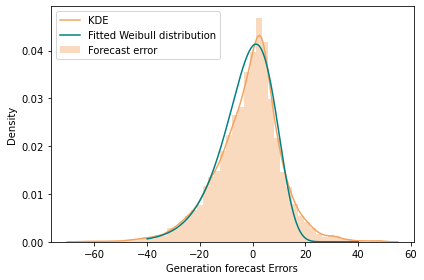

In [45]:


sns.distplot(errors, kde=True, color='sandybrown', hist_kws={'label':'Forecast error'}, kde_kws={'label': 'KDE'})


# Fit the weibull distribution!
plt.plot(x_weib, frozen_dist.pdf(x_weib), label='Fitted Weibull distribution', color='teal')

# plt.title('Error PDF fitted by KDE and Weibull distribution')

plt.xlabel('Generation forecast Errors')
plt.legend()
plt.tight_layout()
plt.savefig('kernel_density_estimation.png', pad_inches=0.2, dpi=300)

In [46]:
st.weibull_min.ppf(0.5, c=2.2)

0.8465408829809947

### Ploting different fitted PDF's

Weibull parameters: c=0.23121310613321622, loc=-64.32695012841624, scale=1.9790191628927851


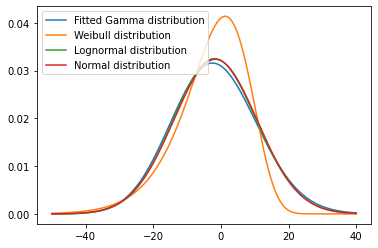

In [47]:


x = np.linspace(-50, 40, 1000)
x_weib = np.linspace(-40, 40, 1000)

alpha, loc, beta = st.gamma.fit(errors)
y_g=st.gamma.pdf(x, a=alpha, loc=loc, scale=beta)

c_weibull, loc_weibull, scale_weibull = st.weibull_min.fit(errors)
print(f'Weibull parameters: c={c_weibull}, loc={loc_weibull}, scale={scale_weibull}')
y_weib = st.weibull_min.pdf(x_weib, c=16.15, loc=-141, scale=142)
# y_weib = st.weibull_min.pdf(x_weib, c, loc=loc, scale=scale)

s, loc, scale = st.lognorm.fit(errors)
y_lognorm = st.lognorm.pdf(x, s, loc=loc, scale=scale)

loc, scale = st.norm.fit(errors)
y_norm = st.norm.pdf(x, loc=loc, scale=scale)

plt.plot(x, y_g, label='Fitted Gamma distribution')
plt.plot(x, frozen_dist.pdf(x), label='Weibull distribution')
plt.plot(x, y_lognorm, label='Lognormal distribution')
plt.plot(x, y_norm, label='Normal distribution')


plt.legend()
plt.show()


### Explore, how to take confidence intervals from weibull distribution

We can calculate different percentiles, using `rv.ppf(percentile)` function! rv is the frozen random variable

In [48]:
percentile = 0.01
print(f"There is {percentile*100}% that wind forecast error is bigger than {frozen_dist.ppf(0.01)}")

There is 1.0% that wind forecast error is bigger than -33.770986870374486


<AxesSubplot:ylabel='Density'>

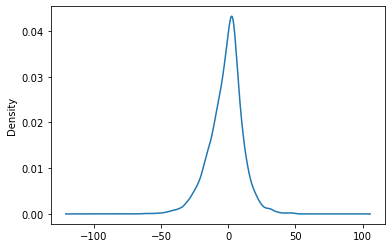

In [52]:
errors.plot.kde()


In [53]:


stat, p = shapiro(errors)
print('Sharpe-Wilk test=%.3f, p=%.3f' % (stat, p))
print("Since p<0.05, we can say, that H1, aka the data is NOT from gaussian distribution")

Sharpe-Wilk test=0.977, p=0.000
Since p<0.05, we can say, that H1, aka the data is NOT from gaussian distribution


/home/da5id/.local/lib/python3.9/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [54]:
error_mean = errors.mean()
error_std = errors.std()

print("errors mean:",round(error_mean, 2))
print('errors standard deviation', round(error_std, 2))

errors mean: -1.62
errors standard deviation 12.33


In [55]:
error_mean = -141**(1/2)
error_std = 142**(1/2)
c_weib = 12
print("errors mean:",round(error_mean, 2))
print('errors standard deviation', round(error_std, 2))

errors mean: -11.87
errors standard deviation 11.92


In [56]:
df_forecasts

,EG DA Wind,Wind park ID position fixed 2 hours before,Wind park ID position fixed 3_hours_before
Unnamed: 0,,,
2021-01-01 00:00:00,19.6,21.283654,19.673898
2021-01-01 01:00:00,22.3,20.442779,20.278637
2021-01-01 02:00:00,20.7,22.023503,19.711593
2021-01-01 03:00:00,19.3,20.797317,20.636694
2021-01-01 04:00:00,18.1,17.463922,19.499845
...,...,...,...
2022-03-31 19:00:00,4.5,3.991464,3.715100
2022-03-31 20:00:00,4.7,3.327443,3.620040
2022-03-31 21:00:00,5.3,3.154586,3.692790


### Graafiku tõlgendus

Kuna teeme pigem vigu alahindamisel, siis 

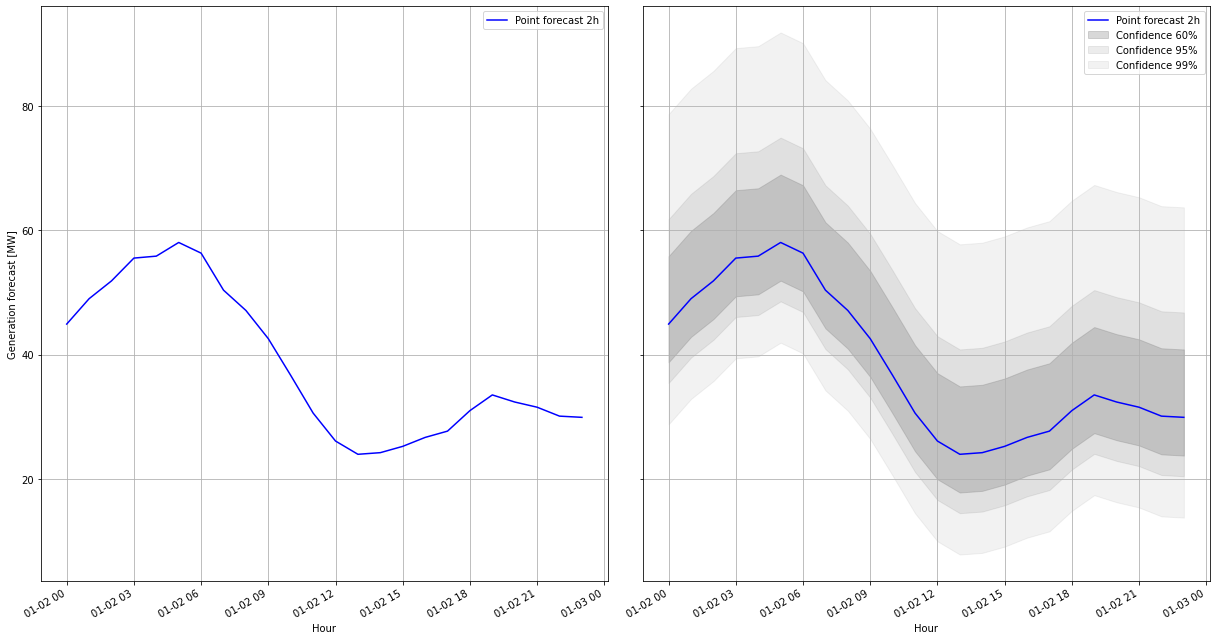

In [57]:

fig, ax = plt.subplots(1, 2, figsize=(17, 9), sharey=True)

ax[0].plot(last_forecast.index[24:48], last_forecast[24:48], color='blue', label='Point forecast 2h')


ax[1].plot(last_forecast.index[24:48], last_forecast[24:48], color='blue', label='Point forecast 2h')
ax[1].fill_between(last_forecast.index[24:48], 
                last_forecast.iloc[24:48] - frozen_dist.ppf(0.8),
                last_forecast.iloc[24:48] - frozen_dist.ppf(0.2),
                alpha=0.30, color='grey', label='Confidence 60%')

# The 2- sigma band - 66.7% confidence
ax[1].fill_between(last_forecast.index[24:48], 
                last_forecast.iloc[24:48] - frozen_dist.ppf(0.9),
                last_forecast.iloc[24:48] - frozen_dist.ppf(0.1),
                alpha=0.15, color='grey', label='Confidence 95%')

# The 3- sigma band - 97% confidence
ax[1].fill_between(last_forecast.index[24:48], 
                last_forecast.iloc[24:48] - frozen_dist.ppf(0.99),
                last_forecast.iloc[24:48] - frozen_dist.ppf(0.01),
                alpha=0.10, color='grey', label='Confidence 99%')

plt.legend(loc='best')
# Fit the dates correctly
plt.gcf().autofmt_xdate()


# ax[0].title.set_text("Point forecast of wind generation, 2h before")
# ax[1].title.set_text("Probabilistic forecast of wind generation, 2h before")

ax[0].set_xlabel('Hour')
ax[1].set_xlabel('Hour')

ax[0].grid(visible=True)
ax[1].grid(visible=True)

ax[0].set_ylabel('Generation forecast [MW]')
ax[0].legend(loc='best')
plt.tight_layout()
plt.savefig('point_vs_prob_forecast_example.png', pad_inches=0.2, dpi=300)

In [58]:
last_forecast.index[24:48]

DatetimeIndex(['2021-01-02 00:00:00', '2021-01-02 01:00:00',
               '2021-01-02 02:00:00', '2021-01-02 03:00:00',
               '2021-01-02 04:00:00', '2021-01-02 05:00:00',
               '2021-01-02 06:00:00', '2021-01-02 07:00:00',
               '2021-01-02 08:00:00', '2021-01-02 09:00:00',
               '2021-01-02 10:00:00', '2021-01-02 11:00:00',
               '2021-01-02 12:00:00', '2021-01-02 13:00:00',
               '2021-01-02 14:00:00', '2021-01-02 15:00:00',
               '2021-01-02 16:00:00', '2021-01-02 17:00:00',
               '2021-01-02 18:00:00', '2021-01-02 19:00:00',
               '2021-01-02 20:00:00', '2021-01-02 21:00:00',
               '2021-01-02 22:00:00', '2021-01-02 23:00:00'],
              dtype='datetime64[ns]', name='Unnamed: 0', freq=None)

### An example of CDF's

I need inverse of CDF (PPF) inside the model. Model the data and get comfortable with CDF's

Last forecast 21.283654071963994
For alpha=0.78, gen value is 30.885890542563683


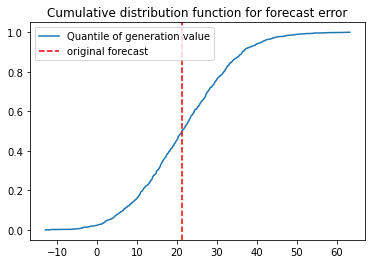

Last forecast 20.44277916476272
For alpha=0.78, gen value is 29.55735254911098


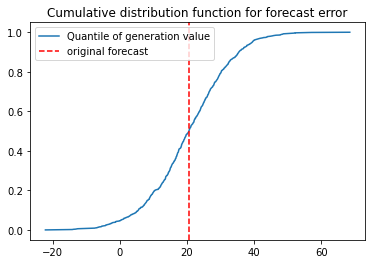

Last forecast 22.023503182922003
For alpha=0.78, gen value is 31.70854290509419


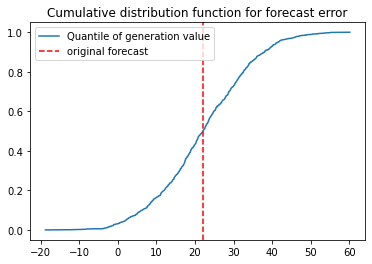

Last forecast 20.797316812371303
For alpha=0.78, gen value is 29.804927402399894


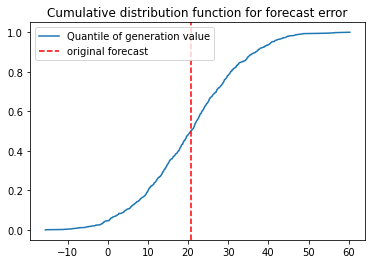

Last forecast 17.463921747767102
For alpha=0.78, gen value is 26.058089405622887


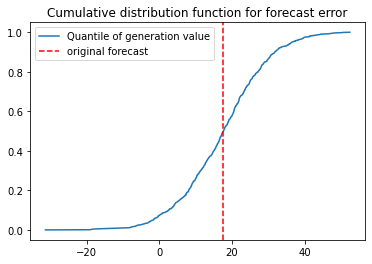

In [59]:



for hour in range(5):
    # Every hour, we deal with a different random variable
    # We have the mean, as the point estimate, and error distribution
    forecasted_value = last_forecast[hour]
    
    # Normal distribution N(X| error_mu+forecast, error_stderr)
    x = error_std * np.random.randn(1, 1000) + forecasted_value
    x = np.sort(x)

    y = 1. * np.arange(len(x[0])) / (len(x[0]) - 1)
    
    # Print first 
    print('Last forecast', forecasted_value)
    
    alpha=0.78

    optimal_quantile_value = x[0][int(alpha*1000)]
    
    print('For alpha=0.78, gen value is', optimal_quantile_value)
    plt.plot(x[0], y, label='Quantile of generation value')
    plt.title('Cumulative distribution function for forecast error')
    plt.axvline(x=forecasted_value, c='r', linestyle='--', label='original forecast')
    plt.legend()
    plt.show()

<a id='static_alpha'></a>
## Test with static alpha

Later on, the alpha will be substituted with specific calculation of alpha (optimal quantile) for each hour! This will be the surrounding structure, that supports this modelling

In [60]:
spot_revenue = 0

ALPHA = 0.5  # To be determined as a loss function from marginal prices (asymmetry between 2 balancing market sizes)

eg_perfect = calculate_perfect_revenue(df_prices, df_real)
eg_spot_revenue = calculate_spot_revenue(df_forecasts, df_prices, alpha=ALPHA)
eg_balancing_revenue = calculate_balancing_revenue(df_forecasts, df_prices, df_imb_prices, df_real, alpha=ALPHA)

total_revenues, performance_rates = calculate_total_performances(eg_spot_revenue, eg_balancing_revenue, eg_perfect)
performance_rates

Perfect Spot revenue in 2021-01 is 2,193,107.53 EUR
Perfect Spot revenue in 2021-02 is 2,175,418.67 EUR
Perfect Spot revenue in 2021-03 is 2,655,455.87 EUR
Perfect Spot revenue in 2021-04 is 2,015,695.54 EUR
Perfect Spot revenue in 2021-05 is 1,868,423.55 EUR
Perfect Spot revenue in 2021-06 is 1,248,509.45 EUR
Perfect Spot revenue in 2021-07 is 2,312,166.61 EUR
Perfect Spot revenue in 2021-08 is 3,973,589.49 EUR
Perfect Spot revenue in 2021-09 is 5,546,917.69 EUR
Perfect Spot revenue in 2021-10 is 7,604,991.96 EUR
Perfect Spot revenue in 2021-11 is 6,917,440.56 EUR
Perfect Spot revenue in 2021-12 is 10,284,437.9 EUR
Perfect Spot revenue in 2022-01 is 9,822,150.02 EUR
Perfect Spot revenue in 2022-02 is 6,032,999.01 EUR
Perfect Spot revenue in 2022-03 is 2,998,229.07 EUR
Spot revenue in 2021-01 is 2,233,800.74 EUR
Spot revenue in 2021-02 is 2,093,019.89 EUR
Spot revenue in 2021-03 is 2,674,011.02 EUR
Spot revenue in 2021-04 is 1,984,624.91 EUR
Spot revenue in 2021-05 is 1,992,003.9 EUR
S

[0.9682246679441204,
 0.9758112354528979,
 0.986871967862904,
 0.9473458327937759,
 0.9630488279812144,
 0.9485802209987279,
 0.9598226833662303,
 0.9366876471177699,
 0.9926972217249539,
 0.9700575239003935,
 0.9831334076544636,
 0.9782267643426579,
 0.9909623728186551,
 0.9831180844168579,
 0.9565543069062432]

## Functions for calculating alpha in every hour

In [61]:
df_timeseries = pd.read_csv('../../data/imbalance_strategy/test_small_imb_volumes.csv', parse_dates=True)
# df_timeseries.drop(['Unnamed: 0', 'to'], inplace=True, axis=1)


df_timeseries['from'] = pd.to_datetime(df_timeseries['from'])
df_timeseries.index = df_timeseries.iloc[:, 0]  # Change the col to index with datetimes, instead of integers!
df_timeseries.drop('from', axis=1, inplace=True) 

df_timeseries

,Baltics
from,
2021-11-01 00:00:00,5.56
2021-11-01 01:00:00,42.08
2021-11-01 02:00:00,22.10
2021-11-01 03:00:00,119.31
2021-11-01 04:00:00,83.09
...,...
2022-03-26 19:00:00,78.10
2022-03-26 20:00:00,70.99
2022-03-26 21:00:00,33.34


In [62]:

model = sm.tsa.arima.ARIMA(df_timeseries['Baltics'], order=(3, 0, 1))
fitted_model = model.fit()

/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


---

<a id='loss_fun'></a>
## Development of the loss function

Loss function is the basis for optimal quantile selection. It is the interface for our forecast results, it has to give the information, which way the asymmetry is more costly.

In [63]:
x=[-1, 0, 1]
pi=[7, 0, 4]

$$\pi_i^+ = \lambda_i^S - \lambda_i^\downarrow$$
$$\pi_i^- = \lambda_i^\uparrow - \lambda_i^S$$

Optimal quantile comes from the loss function:  
$$\alpha^*=\frac{\pi_i^+}{\pi_i^+ + \pi_i^-}$$

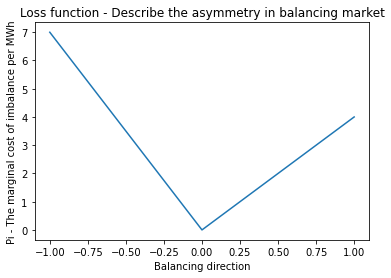

In [64]:
plt.plot(x, pi)
plt.ylabel('Pi - The marginal cost of imbalance per MWh')
plt.xlabel('Balancing direction')
plt.title("Loss function - Describe the asymmetry in balancing market")

plt.show()

Here, 

$$\alpha^*=\frac{7}{7 + 4}=0.78$$

So we take the .78 quantile from the probabilistic prediction of generation

$$E_i^* = F_i^{-1}(0.78)$$

The plot shows expected asymmetry of different balancing market sides (UP-DOWN). If the first half slope is higher, **it means, that probably, the Day-ahead electricity price is higher than the balancing price in specific hour (spread is negative)**

---

## Calculate the actual loss function

In [65]:
AGGREGATION_STEP = 60
ASYMMETRY_MULTIPLIER = 0.1

In [66]:
def change_timeseries_aggregation_step(timeseries_df: pd.DataFrame, aggregation_step: int):
    '''
    Take univariate timeseries with 1min data and aggregate.
    :param timeseries:
    :param aggregation_step:
    :return:
    '''
    n_count = timeseries_df.shape[0]
    n_count_aggregated = round(n_count / aggregation_step)
    new_entries = {'from': [], 'aggregate': []}
    for i in range(0, n_count, aggregation_step):
        chunk = timeseries_df.iloc[i:(i + aggregation_step), :]
        aggregate = (chunk.iloc[:, 1].mean())

        new_entry_timestamp = str(chunk.index[0]).split('+')[0]
        new_entries['from'].append(new_entry_timestamp)
        new_entries['aggregate'].append(aggregate)
    aggregated_df = pd.DataFrame(data=new_entries)
    return aggregated_df

In [67]:
df_timeseries['Baltics'].interpolate(method='spline', order=3, inplace=True)

In [68]:
model = sm.tsa.arima.ARIMA(df_timeseries['Baltics'], order=(3, 0, 1))
fitted = model.fit()

/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [69]:
forecasted_imbalance = fitted.get_forecast(4)
forecasted_imbalance_point_value = forecasted_imbalance.predicted_mean[-1]
# forecasted_imbalance=50
loss_function_value = forecasted_imbalance_point_value * 0.1
x=[-1, 0, 1]
if forecasted_imbalance_point_value > 0:
    pi=[1, 0, loss_function_value]
else:
    pi=[abs(loss_function_value), 0, 1]


In [70]:
forecasted_imbalance

In [71]:
forecasted_imbalance_ci = forecasted_imbalance.conf_int(alpha=(1-0.66))
forecasted_imbalance_ci

,lower Baltics,upper Baltics
2022-03-27 00:00:00,-22.577263,75.580823
2022-03-27 01:00:00,-35.994759,89.395151
2022-03-27 02:00:00,-39.793624,94.139401
2022-03-27 03:00:00,-41.349997,95.472830


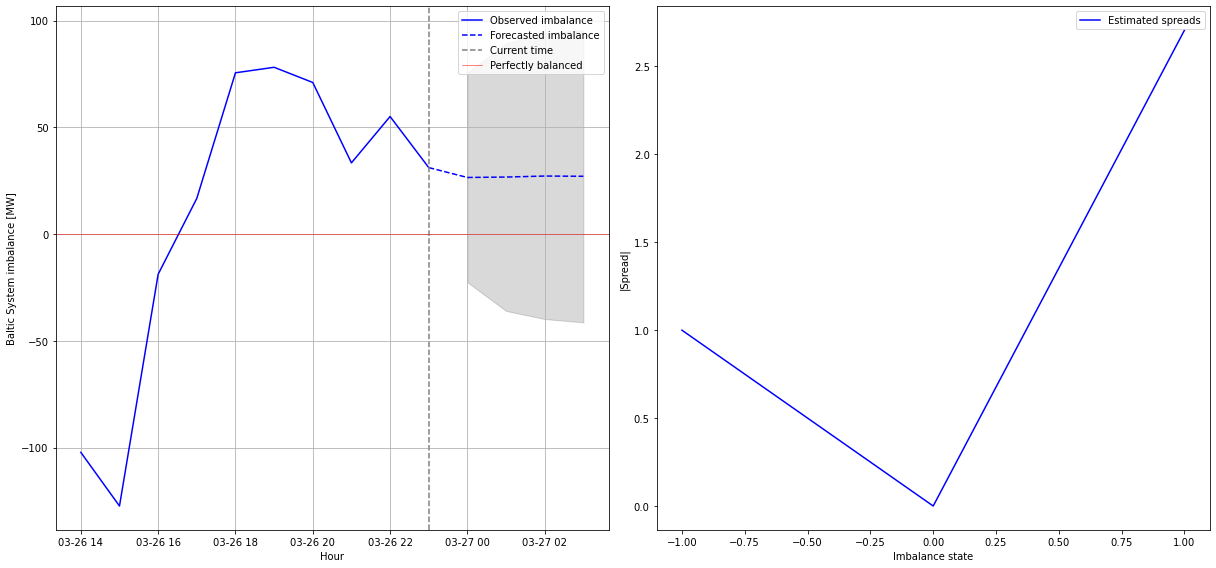

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(17, 8))

# Concat the observed and forecasted
ax[0].plot(df_timeseries.iloc[-10:], label='Observed imbalance', c='b')

# Add one last observation, to remove the gap
forecasted_df = pd.DataFrame(data=forecasted_imbalance.predicted_mean)
forecasted_imbalance_df = forecasted_df.rename(columns={'predicted_mean':'Baltics'})
forecasted_imbalance_df = pd.concat([df_timeseries[-1:], forecasted_imbalance_df])

ax[0].plot(forecasted_imbalance_df, c='b', linestyle='--', label='Forecasted imbalance')

ax[0].fill_between(forecasted_imbalance_ci.index,
                    forecasted_imbalance_ci.iloc[:, 0],
                    forecasted_imbalance_ci.iloc[:, 1], color='k', alpha=.15)
# 
# ax[0].title.set_text('Forecasted system imbalance')
ax[0].set_ylabel('Baltic System imbalance [MW]')
ax[0].set_xlabel('Hour')

# Note the current and the  delivery hours
ax[0].axvline(x=df_timeseries.index[-1], linestyle='--', c='grey', label='Current time')
ax[0].axhline(y=0, c='r', linewidth=0.5,label='Perfectly balanced')
ax[0].legend(loc='best')
ax[0].grid(visible=True)

# The imbalance spread asymmetry function 
ax[1].plot(x, pi, label='Estimated spreads', c='b')
# ax[1].title.set_text('Imbalance Spread Asymmetry function')
ax[1].set_ylabel('|Spread|')
ax[1].set_xlabel('Imbalance state')
ax[1].legend(loc='best')

plt.tight_layout()
plt.savefig('imbalnace_spread_asymmetry_function.png', pad_inches=0.2, dpi=300)

In [73]:
def calculate_optimal_quantile(forecasted_imbalance, asymmetry_multiplier=0.05):
    """
    model: Could be whatever estimator, to predict imbalance state. Could be a wrapper class, that has forecast() method
    asymmetry_multiplier: Hyperparameter, that increases the asymmetry. Higher value puts more confidence to prediction result.
    
    return: Alpha - the wind forecast quantile, that optimizes the profits, given imbalance market state estimation.
    """
    loss_function_value = forecasted_imbalance * asymmetry_multiplier
    x=[-1, 0, 1]
    
    if forecasted_imbalance > 0:
        pi=[1, 0, loss_function_value]
    else:
        pi=[abs(loss_function_value), 0, 1]
        
    optimal_quantile =loss_function_value/(loss_function_value + 1) if forecasted_imbalance>0 else 1/(abs(loss_function_value)+1)
    
    return optimal_quantile

In [74]:
pred = fitted.get_forecast(2)
point= pred.predicted_mean[-1]
prob = pred.conf_int(alpha=0.05)
prob

,lower Baltics,upper Baltics
2022-03-27 00:00:00,-74.312158,127.315719
2022-03-27 01:00:00,-102.082375,155.482767


In [75]:
alpha = calculate_optimal_quantile(point)
alpha

0.5717362710707936

<a id='tests'></a>
## Backtesting revenue calculation functions for optimal quantile logic 

In [76]:
def calculate_spot_revenue_optimal_quantile(df_forecast, df_market, df_system_imb) -> list:
    """
    Calculate the real revenue from selling electricity to SPOT market. 
    
    Optimal quantile calculation in every hour is included. The calculation of optimal quantile 
    (including the forecast) should be done inside this function!
    """
    
    SOLD_QUANTITY_FORECAST_IDX = 0
    
    SPOT_PRICE_IDX = 0
    IMBALANCE_PRICE_IDX = 0
    ROUNDING_PRECISION = 2
    
    spot_revenues=[]
    
    # First, look monthly data
    periods=['2021-11']

    
    for period in periods:
        spot_revenue = 0
        
        df_market_period = df_market.loc[period]
        df_forecast_period = df_forecast.loc[period]
        df_system_imbalance_period = df_system_imb.loc[period]

        # Calculate total revenue for whole month
        for i in range(len(df_system_imbalance_period)):
            

            imbalance_forecast = df_system_imbalance_period.iloc[i, 0]
            print('forecasted imbalance',imbalance_forecast)
            alpha = calculate_optimal_quantile(imbalance_forecast)
            print(alpha)
            
            
            # ---- The choosing of determined quantile -----------
            forecasted_value = df_forecast_period.iloc[i, SOLD_QUANTITY_FORECAST_IDX]

            
            optimal_quantile_weibull = forecasted_value + frozen_dist.ppf(alpha) 
            #print(optimal_quantile_weibull)

            sold = optimal_quantile_weibull

            price = df_market_period.iloc[i,SPOT_PRICE_IDX]
            hour_revenue = sold * price
            spot_revenue += hour_revenue
        print(f'Spot revenue {round(spot_revenue, ROUNDING_PRECISION):,} EUR')
        spot_revenues.append(round(spot_revenue, ROUNDING_PRECISION))
        
    
    return spot_revenues

In [77]:
def calculate_balancing_revenue_optimal_quantile(df_forecast, df_market, df_real, df_system_imb) -> list:
    """
    Calculate the real revenue from selling electricity to SPOT market. 
    tau - Coefficent, to multiply the mean forecst with
    alpha - Quantile of the forecast, to place in the market (DA or ID)
    """
    
    SOLD_QUANTITY_FORECAST_IDX = 0    
    QUANTITY_ACTUAL_IDX = 0
    
    SPOT_PRICE_IDX = 0
    IMBALANCE_PRICE_IDX = 0
    ROUNDING_PRECISION = 2
        
    balancing_revenues = []
    
    # First, look monthly data
    periods=['2021-11']

    
    for period in periods:
        
        df_forecast_period = df_forecast.loc[period]
        df_market_period = df_market.loc[period]
        df_real_period = df_real.loc[period]
        df_system_imbalance_period = df_system_imb.loc[period]
        
        balancing_revenue = 0

        # Calculate total revenue for whole month
        for i in range(len(df_system_imbalance_period)):
            
            imbalance_forecast = df_system_imbalance_period.iloc[i, 0]
            print('forecasted imbalance',imbalance_forecast)
            alpha = calculate_optimal_quantile(imbalance_forecast)
            print(alpha)
                
            # ---- The choosing of determined quantile -----------

            forecasted_value = df_forecast_period.iloc[i, SOLD_QUANTITY_FORECAST_IDX]
            
            optimal_quantile_weibull = forecasted_value + frozen_dist.ppf(alpha) 
            print(optimal_quantile_weibull)

            sold = optimal_quantile_weibull

        
            production = df_real.iloc[i, QUANTITY_ACTUAL_IDX]
            # print(sold)
            

            imbalance_price = df_imb_prices.iloc[i, IMBALANCE_PRICE_IDX]
            # Have to sell on Balancing market
            if production > sold:
                surplus_generation = production - sold
                surplus = surplus_generation * imbalance_price
                balancing_revenue += surplus
            else:
                # Have to buy from Balancing market
                deficit_generation = sold - production
                deficit = deficit_generation * imbalance_price
                balancing_revenue -= deficit
        print(f'Balancing revenue {round(balancing_revenue, ROUNDING_PRECISION):,} EUR')

        balancing_revenues.append(round(balancing_revenue, ROUNDING_PRECISION))
        
    
    return balancing_revenues

In [78]:
eg_spot_revenue = calculate_spot_revenue_optimal_quantile(df_forecasts, df_prices, df_system_imb_forecast)
eg_balancing_revenue = calculate_balancing_revenue_optimal_quantile(df_forecasts, df_prices, df_real, df_system_imb_forecast)
eg_perfect_capped = calculate_perfect_revenue(df_prices, df_real)

total_revenues, performance_rates = calculate_total_performances(eg_spot_revenue, eg_balancing_revenue, eg_perfect_capped)
performance_rates

forecasted imbalance 64.6458499793546
0.7637214346021917
forecasted imbalance 15.1669471422589
0.4312841567084254
forecasted imbalance 7.426727553161
0.27078431208265136
forecasted imbalance 35.348128044543
0.6386508323478542
forecasted imbalance 24.6718289716723
0.5522905495388922
forecasted imbalance 100.918423624931
0.834599233099195
forecasted imbalance 86.5510213046212
0.8122964965035715
forecasted imbalance 77.7327289740148
0.7953602625245674
forecasted imbalance 121.11370473719
0.858270321530797
forecasted imbalance 195.500061672428
0.9071926019659284
forecasted imbalance 134.809008632179
0.8708085519265916
forecasted imbalance 115.282303009832
0.852161002917385
forecasted imbalance 179.639756635785
0.8998195532942508
forecasted imbalance 233.139368659974
0.9209921392082449
forecasted imbalance 224.014634334115
0.9180377027198493
forecasted imbalance 262.072493655167
0.9290962413922927
forecasted imbalance 212.245819899219
0.9138843488822368
forecasted imbalance 171.42568987716


forecasted imbalance -12.343935461374
0.6183539422370088
forecasted imbalance 29.9643967799546
0.5997149712808326
forecasted imbalance 51.9964711304465
0.7222086070890463
forecasted imbalance 55.3074767378535
0.7344221202680803
forecasted imbalance 48.8309577988504
0.7094330714030245
forecasted imbalance 50.2457831375714
0.7152854006790498
forecasted imbalance 57.2627105720676
0.7411429154903284
forecasted imbalance 106.310117720691
0.8416595569626029
forecasted imbalance 124.254346719942
0.8613559975504352
forecasted imbalance 126.425401457236
0.8634116772024623
forecasted imbalance 7.1120827823113
0.2623215206082001
forecasted imbalance -132.808913555915
0.1308824173576871
forecasted imbalance -140.708771964989
0.12444871400272457
forecasted imbalance -106.653252357582
0.15791146005105106
forecasted imbalance -86.254593974436
0.18822715566361148
forecasted imbalance -40.467568189054
0.33075581834991763
forecasted imbalance -43.0179243998489
0.3173700211562023
forecasted imbalance -88

46.44292509694787
forecasted imbalance 43.0514023200254
0.6827984903731806
58.478842506820996
forecasted imbalance 10.8581297239398
0.35187258012970374
68.18850222371917
forecasted imbalance -39.5370678347747
0.33592517615249945
85.9015866554529
forecasted imbalance -67.5500428050954
0.22844077922981898
101.81004321119205
forecasted imbalance -73.2204533257912
0.2145451913873779
119.52743822946695
forecasted imbalance -103.471324051656
0.16198093082433224
133.60633264266343
forecasted imbalance -134.68268120716
0.12929695712485642
146.87069774460753
forecasted imbalance -44.1129274385252
0.31194956772449733
167.34013881997095
forecasted imbalance 21.4000710704457
0.5169090418717321
184.03561860941346
forecasted imbalance -62.0388361408761
0.2437869787140354
186.72242944786893
forecasted imbalance -112.55733174562
0.15087811241086516
190.68909681492772
forecasted imbalance -144.969160545654
0.12123478069384455
194.72953519463562
forecasted imbalance -72.1032488557887
0.21714760606669953

59.50666575085196
forecasted imbalance 6.47767342285365
0.24464662432397033
47.05585260008775
forecasted imbalance 73.8287720110506
0.7868457662683199
59.67608676207114
forecasted imbalance 83.2031568463262
0.8062074784225755
55.82458145175639
forecasted imbalance 105.676942534557
0.8408618192274955
50.67049172667339
forecasted imbalance 15.7869804317923
0.44113753776687803
35.29720398537141
forecasted imbalance -85.8838088670406
0.1888862916247583
21.368183094443054
forecasted imbalance 0.504517549380747
0.024605189961954696
-2.0317464015759867
forecasted imbalance 78.4247808848316
0.796799141230476
26.355368133193124
forecasted imbalance 37.3855346630961
0.6514801139796342
18.011828402217287
forecasted imbalance -19.7600585286065
0.5030173681864787
11.788863173879584
forecasted imbalance -40.5000789209163
0.33057808116487475
5.334980058324641
forecasted imbalance -62.6669595684511
0.24193462665624357
1.3501043883964865
forecasted imbalance -47.7899294727052
0.2950290722466788
3.17843

Perfect Spot revenue in 2021-06 is 1,248,509.45 EUR
Perfect Spot revenue in 2021-07 is 2,312,166.61 EUR
Perfect Spot revenue in 2021-08 is 3,973,589.49 EUR
Perfect Spot revenue in 2021-09 is 5,546,917.69 EUR
Perfect Spot revenue in 2021-10 is 7,604,991.96 EUR
Perfect Spot revenue in 2021-11 is 6,917,440.56 EUR
Perfect Spot revenue in 2021-12 is 10,284,437.9 EUR
Perfect Spot revenue in 2022-01 is 9,822,150.02 EUR
Perfect Spot revenue in 2022-02 is 6,032,999.01 EUR
Perfect Spot revenue in 2022-03 is 2,998,229.07 EUR


[2.3281809351135645]